- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python 
    !git pull



Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1297 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1163 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [30.2 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2294 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [53.8 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [27.1 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1863 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1218 kB]
Get:13 http:

- enable module autoreload and fix an import bug

In [2]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [4]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import time
from scripts.DataGenerator import DataGenerator

- model parameters

In [21]:
_batch_size = 8
_epochs = 200
_workers = 8
_model_name = f'RBC_BinaryCrossentropy_data2_data2_60'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
#validation_steps = len(test_img_tile_files)//_batch_size

Train = True

In [22]:
database = "data"


train_img_tile_files = sorted(glob.glob(f'{database}/train/tiles/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database}/train/mask/tiles/*.jpg'))
train_edge_tile_label_files = sorted(glob.glob(f'{database}/train/edge/tiles/*.jpg'))

database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, train_edge_tile_label_files, _batch_size, skip_empty = True, noise_prob = 0)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = True, augment=False)



skipping empty images with keep probability of 0.05
before skip we have 6640 images


100%|██████████| 6640/6640 [00:00<00:00, 35112.27it/s]


after skip we have 4832 images
skipping empty images with keep probability of 0.05
before skip we have 1834 images


100%|██████████| 1834/1834 [00:00<00:00, 15192.40it/s]

after skip we have 1312 images


- load weights and compile it

In [23]:
print(f"loading model {_model_name}")
#unet.load_weights(f"models/{_model_name}_best.h5")

#unet.save('./tmp_model',save_format='tf')

objects = {
    "tversky_loss":model.tversky_loss,
    "mean_iou": model.mean_iou,
    "dsc":model.dsc,
    "tversky":model.tversky,
    "tversky_b":model.tversky_b,
    "acc": tf.keras.metrics.Accuracy,
    "tversky_loss_b": model.tversky_loss_b
}



unet = tf.keras.models.load_model(f'./models/{_model_name}', custom_objects=objects)

print(len(unet.layers))

layers = []
#freeze the layers
#freeze the all the layers
#layers = range(0, 66)
#freeze the edge layer
#layers = [-1]
for ind in layers:
    #print(f"freezing layer {unet.layers[ind].name}")
    unet.layers[ind].trainable = False

unet.compile(optimizer="adam",
             loss=model.tversky_loss,
             loss_weights={"mask": 0.3, "edge": 0.7},
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})




layers = [(layer.name, layer.output.shape, layer.trainable) for layer in unet.layers]
df = pd.DataFrame(layers, columns=['Layer Name', 'Output Shape', 'Layer Trainable'])

print(df.to_string())

#unet.summary()

loading model RBC_BinaryCrossentropy_data2_data2_60
66
                Layer Name          Output Shape  Layer Trainable
0                  input_4   (None, 188, 188, 3)             True
1                conv2d_45  (None, 186, 186, 96)             True
2   batch_normalization_54  (None, 186, 186, 96)             True
3            activation_54  (None, 186, 186, 96)             True
4                conv2d_46  (None, 186, 186, 32)             True
5   batch_normalization_55  (None, 186, 186, 32)             True
6            activation_55  (None, 186, 186, 32)             True
7                conv2d_47  (None, 184, 184, 32)             True
8   batch_normalization_56  (None, 184, 184, 32)             True
9            activation_56  (None, 184, 184, 32)             True
10         max_pooling2d_9    (None, 92, 92, 32)             True
11               conv2d_48    (None, 90, 90, 64)             True
12  batch_normalization_57    (None, 90, 90, 64)             True
13           activati

- evaluate the model before train

In [7]:
old_database = database
database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

old_test_gen = test_gen
test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = False, augment=False)

unet.evaluate(test_gen)

database = old_database
test_gen = old_test_gen

Instructions for updating:
Use fn_output_signature instead


2022-06-04 22:14:39.362895: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


229/229 [==============================] - 21s 70ms/step - loss: 0.1982 - mask_loss: 0.1982 - edge_loss: 0.7633 - mask_mean_iou: 0.5314 - mask_dsc: 0.7989 - mask_tversky: 0.8018 - mask_tversky_b: 0.9588 - mask_acc: 0.9740 - edge_mean_iou: 0.0576 - edge_dsc: 0.1677 - edge_tversky: 0.2367 - edge_tversky_b: 0.3794 - edge_acc: 0.7129


- Train the model

In [ ]:
if Train:
    _model_name_new = _model_name + "_data_data_200_03_07__" + str(time.time()) + "_adv"
    try:
        os.remove(f"models/{_model_name}_best.h5")
        os.remove(f"models/{_model_name}_all.h5")
    except:
        pass
    
    history = unet.fit(train_gen, 
            epochs=_epochs, 
            validation_data=test_gen, 
            steps_per_epoch=train_steps,
            max_queue_size=2*_workers,
            use_multiprocessing=True,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name_new))
    
    unet.save(f'./models/{_model_name_new}',save_format='tf')

Epoch 1/200
125/125 [==============================] - ETA: 0s - loss: 0.3440 - mask_loss: 0.1254 - edge_loss: 0.4377 - mask_mean_iou: 0.6880 - mask_dsc: 0.8618 - mask_tversky: 0.8746 - mask_tversky_b: 0.8750 - mask_acc: 0.9430 - edge_mean_iou: 0.2911 - edge_dsc: 0.4896 - edge_tversky: 0.5623 - edge_tversky_b: 0.5626 - edge_acc: 0.9228
Epoch 00001: val_loss improved from inf to 0.29064, saving model to models/RBC_BinaryCrossentropy_data2_data2_60_data_data_200_03_07__1654386321.7190397_adv_best.h5
125/125 [==============================] - 33s 229ms/step - loss: 0.3440 - mask_loss: 0.1254 - edge_loss: 0.4377 - mask_mean_iou: 0.6880 - mask_dsc: 0.8618 - mask_tversky: 0.8746 - mask_tversky_b: 0.8750 - mask_acc: 0.9430 - edge_mean_iou: 0.2911 - edge_dsc: 0.4896 - edge_tversky: 0.5623 - edge_tversky_b: 0.5626 - edge_acc: 0.9228 - val_loss: 0.2906 - val_mask_loss: 0.0685 - val_edge_loss: 0.3858 - val_mask_mean_iou: 0.7567 - val_mask_dsc: 0.9182 - val_mask_tversky: 0.9315 - val_mask_tversky_

- save the training log 

In [ ]:
#save the training log into a file
import json
my_dict = {'a':11,'b':22,'c':33}
with open(f"models/{_model_name}_log.json", "a+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)


- evaluate model after training

In [ ]:
old_database = database
database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

old_test_gen = test_gen
test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = False, augment=False)

unet.evaluate(test_gen)

database = old_database
test_gen = old_test_gen

In [ ]:

images, (masks, edges) = train_gen.__getitem__(165)

#data.plot_ime(images, masks, edges)

prediction = unet.predict(images)

#prediction = np.squeeze(prediction)

data.plot_ime(images, prediction[0], prediction[1])

NameError: name 'img' is not defined

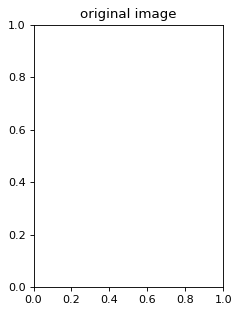

In [16]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                        data.load_data_na(sorted(glob.glob(f'data/test/*.jpg'))[:20] + glob.glob(f'*.jpg'), RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')